In [1]:
# coding: utf-8

# # CS - 587:  Exercise 3b
# 
# We will use a pretrained model, in our case a VGG_16 to compute class saliency maps as described in Section 
# 3.1 of [2].
# 
# A saliency map tells us the degree to which each pixel in the image affects the classification score for 
# that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct 
# class (which is a scalar) with respect to the pixels of the image. If the image has shape (H, W, 3) then 
# this gradient will also have shape (H, W, 3); for each pixel in the image, this gradient tells us the amount
# by which the classification score will change if the pixel changes by a small amount. To compute the saliency
# map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the
# final saliency map thus has shape (H, W) and all entries are nonnegative.
# 
# [2] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. 
# "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", 
# ICLR Workshop 2014.

# In[4]:


import numpy as np
import tensorflow as tf
from models import vgg16
from Utilities import utils
import matplotlib.pyplot as plt

# In[5]:


#Load the image to be processed
img = utils.load_image("flamingo1.jpg")

/home/george/anaconda3/envs/py35env/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


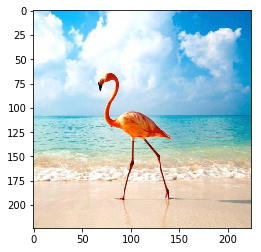

(224, 224, 3)

In [2]:
# Plot the image of this magestic creature
imgplot = plt.imshow(img)
#plt.axis('off')
plt.show()
img.shape

In [3]:
# In[6]:


# Add some useful functions that will ease the visualization process
def VisualizeImageGrayscale(image_3d, percentile=99):
    
    #Returns a 3D tensor as a grayscale 2D tensor, with pixel values in [0,1].

    #This method sums a 3D tensor across the absolute value of axis=2, and then
    #clips values at a given percentile.

    image_2d = np.sum(np.abs(image_3d), axis=2) # sum over the absolute values of RGB channels

    vmax = np.percentile(image_2d, percentile)
    vmin = np.min(image_2d)

    return np.clip((image_2d - vmin) / (vmax - vmin), 0, 1) # standardize and rectify (<0 become 0, and >1 become 1) 

def VisualizeImageDiverging(image_3d, percentile=99):

    #Returns a 3D tensor as a 2D tensor with positive and negative values, with pixel values in [-1,1].
    image_2d = np.sum(image_3d, axis=2)

    span = abs(np.percentile(image_2d, percentile))
    vmin = -span
    vmax = span

    return np.clip((image_2d - vmin) / (vmax - vmin), -1, 1)


In [4]:
# ## Class Saliency Map
# 
# In order to compute the saliency map of a specific class the following steps are required:
# Following are the steps involved:
# 
# 1. Do a forward pass of the image through the network.
# 2. Calculate the scores for every class.
# 3. Enforce derivative of score S at last layer for all classes except class C to be 0. For C, set it to 1.
# 4. Backpropagate this derivative till the start.
# 5. Render the gradients and you have your Saliency Map!
# 
# More information about the role of each step can be found in:
# https://www.silversparro.com/single-post/2018/01/26/Understanding-Deep-Learning-Networks-using-Saliency-Maps

# In[7]:

##############################------PARTs 3 and 4 -------------############################################################
#                                                                                                                         # 
# We will start with steps 3 and 4: we will define a class that enforces the derivative of an input (Score class)         # 
# to be 1 and backpropagates this derivative till the start. The rest of the parts (1,2 and 5) will be implemented        #
# later during the graph call in lines 160 - ... (here you will also call the classes of 3 and 4 that you have filled in  #
###########################################################################################################################

class Saliency(object):
    
    #Base class for saliency masks. Alone, this class doesn't do anything.#
    def __init__(self, graph, session, y, x):
        #Constructs a SaliencyMask by computing dy/dx.

        #Args:
        #  graph: The TensorFlow graph to evaluate masks on.
        #  session: The current TensorFlow session.
        #  y: The output tensor to compute the SaliencyMask against. This tensor
        #      should be of size 1, i.e. the predicted class 'prediction_class' (check below)
        #  x: The input tensor to compute the SaliencyMask against. The outer
        #      dimension should be the batch size.

        # y must be of size one, otherwise the gradient we get from tf.gradients
        # will be summed over all ys.

        size = 1
        for shape in y.shape:
            size *= shape
        assert size == 1

        self.graph = graph
        self.session = session
        self.y = y
        self.x = x

    def Mask_GEN(self, x_value, feed_dict={}):
        #Returns an unsmoothed mask.

        #Args:
        #  x_value: Input value, not batched.
        #  feed_dict: (Optional) feed dictionary to pass to the session.run call.

        raise NotImplementedError('A derived class should implemented GetMask()')

###########################################################################################  
# TODO: Implement the Gradient saliecy class so as to do the following:                   #
#              a) Is a child class of SaliencyMask, use the init function of              #
#                 Saliency class to get the values of graph, x, y. HINT: check super ()   #
#              b) Returns the backward pass (gradient ascent) of the activation           #
#                  w.r.t to the input image. Use tf.gradients() and y,x                   # 
#                                                                                         #
###########################################################################################   

class Get_Gradient(Saliency):
    #A SaliencyMask class that computes saliency masks with a gradient.

    def __init__(self, graph, session, y, x):

        ############################################################
        #       Start of your code #HINT: take a look at tf.gradient
        
        super(Get_Gradient, self).__init__(graph, session, y, x) # inherit methods from class 'Saliency'
        self.gradients_node = tf.gradients(y, x)[0] # y: unnormalized max prob (prob of the correct class), 
                                                    # x: image 
                                                    # gradinets_node: dy/dx 
                                                    #  = d(prob_correct)/d(image) -> (H,W,3)
                                                    # we use zero ([0]) for this reason, that is to keep
                                                    # only the gradients of prob_correct w.r.t. 
                                                    # the 0-layer, i.e. the image,  
                                                    # and discard all the other gradients 
                                                    # of prob_correct w.r.t. the hidden layers 
                                                    # that backpropagate.

        #       End of your code
        ############################################################
        
    def Mask_GEN(self, x_value, feed_dict={}):
        #Returns a vanilla gradient mask.

        #Args:
        #  x_value: Input value, the image not batched.
        #  feed_dict: (Optional) feed dictionary to pass to the session.run call.

        feed_dict[self.x] = x_value # self.x = x_value, i.e. the image
                                    # self.y = y is assigned when we call
                                    # Get_gradient(graph, sess, y, x)
                                    # ,where calling 'y' activates the tensor 
                                    # 'y' (=logits[0][class_selector])  to 
                                    #  look for class_selector. check below the 
                                    # feed_dict = {class_selector: prediction_class}
                                    # to make sense.
                                    # this is equivalent to call 
                                    # gradients_node(feed_dict={self.x: x_value, 
                                    #              class_selector: class_prediction}) 

        return self.session.run(self.gradients_node, feed_dict=feed_dict)[0] # use [0] to 'unfold' from 
                                                                            # (1,H,W,3) to (H,W,3)


In [5]:
######################################################################################
# TODO: Implement entire Saliency computation pipeline by:                           #
#              a) Computing steps 1 and 2                                            #
#                    a.1) Do a forward pass of the image through the network.        #
#                    a.2) Calculate the scores for every class.                      #
#             b) Moving to steps 3 and 4                                             # 
#                 b.1) Take the logit for the specific class (the one that gives     #
#                       the highest prediction)  -- should output 130 - make a print #
#                 b.2) Call Get_Gradient() to compute gradients                      #
#                 b.3) Call Get_Gradient.Mask_GEN for the SPECIFIC GRADIENTS to      #
#                       compute the Mask of activations                              #
#                 b.4) Call VisualizeImageGrayscale to visualize the Saliency Map    #
#                                                                                    #
######################################################################################    

graph = tf.Graph()

with graph.as_default():
    
    # Restore the checkpoint
    sess = tf.Session(graph=graph)

    x = tf.placeholder(tf.float32, [None, 224,224,3])
    model = vgg16.Vgg16().build(x)
    #all_names = [n.name for n in tf.get_default_graph().get_operations()]
    #print(all_names)

    # Construct the scalar neuron tensor.
    logits = graph.get_tensor_by_name('prob:0')
    class_selector = tf.placeholder(tf.int32)
    y = logits[0][class_selector] # prob of the correct class

    # Construct tensor for predictions.
    prediction = tf.argmax(logits, 1)

GOOD TO GO! Weights already downloaded and stored!
Weights have been loaded
Model is ready and feeling strong


In [6]:
# check that they output is something like <tf.Tensor ...>
logits
prediction

<tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>

In [7]:
# forward propagate image and get the class predicted.
img_reshaped = img.reshape(1, 224, 224, 3) 
prediction_class = sess.run(prediction, feed_dict = {x: img_reshaped})[0]
print("Prediction class: " + str(prediction_class))  # Should be 130

Prediction class: 130


In [8]:
# create instance of 'Get_gradient' object that will take on tensors:
# y (prob_correct) and 
# x (image) 
gradient_saliency = Get_Gradient(graph, sess, y, x)

# saliency map (mask) with 3 channels RGB
saliency_mask_3d = gradient_saliency.Mask_GEN(img_reshaped, 
                                            feed_dict = {class_selector: prediction_class})

# 3d -> 1d: saliency map (mask) grayscale 
saliency_mask_1d = VisualizeImageGrayscale(saliency_mask_3d)

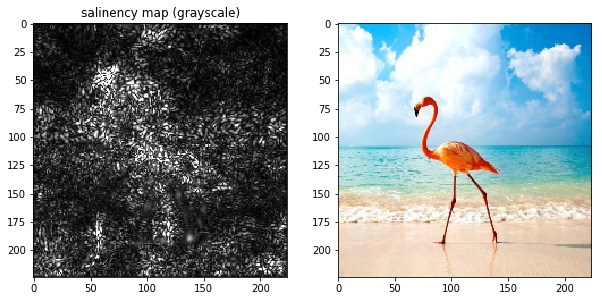

In [9]:
# plot
ROWS = 1
COLS = 2
UPSCALE_FACTOR = 10
plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
plt.subplot(ROWS, COLS, 1)
plt.imshow(saliency_mask_1d , 
         cmap = plt.cm.gray, 
         vmin=0, vmax=1)
title = plt.title('salinency map (grayscale)')
plt.subplot(ROWS, COLS, 2)
plt.imshow(img)

In [10]:
# In[ ]:
  ######################################################################################
  # TODO: Repeat the process for the rest of images, located in folder = MyImages      #
  #              a) Load them and create the tensor to hold them (i.e. correct shape)  #
  #              b) Repeat the steps in previous task for ALL new images               #
  #              c) Show predicted class for each image and plot Saliency Map          #
  #                                                                                    #
  # ####################################################################################           

import os

# change  path
path = os.getcwd()
#for i in range(len(path), 0, -1):
#    if path[-1] != '/':
#        path = path[0:-1]
#    else:
#        break

path = path + '/MyImages'

img_names = os.listdir(path)
num_imgs = len(img_names)

In [11]:
print(img_names)
num_imgs

['doberman.jpg', 'cat.jpg', 'teddybear.jpg']


3

In [12]:
imgs = []
for name in img_names:
    print('reading ...  ' + name)
    tmp = path + '/' + name 
    img = utils.load_image(tmp)
    imgs.append(img) 
imgs = np.stack(imgs)
    
#img_reshaped = img.reshape(1, 224, 224, 3) 
#prediction_class = sess.run(prediction, feed_dict = {x: img_reshaped})[0]
#print("Prediction class: " + str(prediction_class))  # Should be 130

reading ...  doberman.jpg
reading ...  cat.jpg
reading ...  teddybear.jpg


/home/george/anaconda3/envs/py35env/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [13]:
imgs.shape

(3, 224, 224, 3)

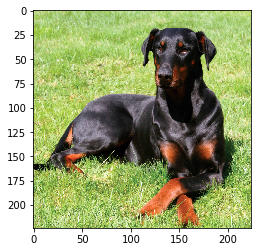

In [14]:
plt.imshow(imgs[0,:,:,:])

In [15]:
prediction_class = sess.run(prediction, feed_dict = {x: imgs})
print("Prediction class: " + str(prediction_class)) 

Prediction class: [236 285 850]


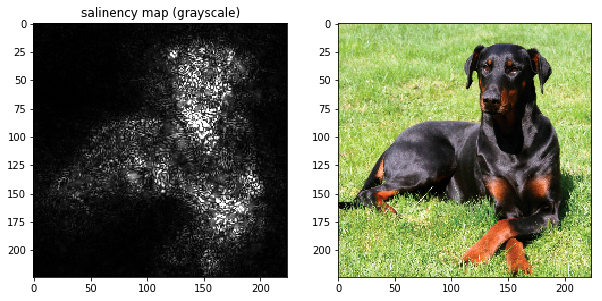

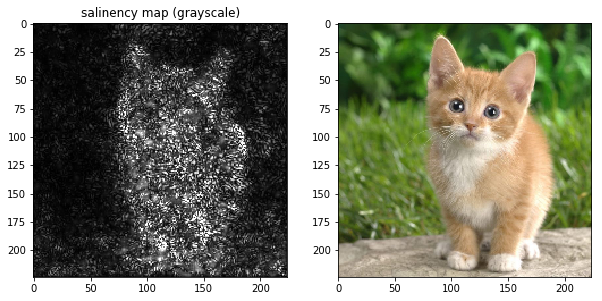

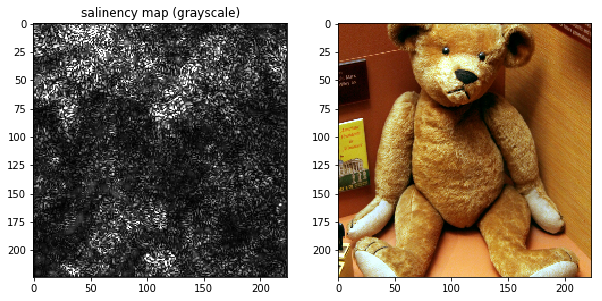

In [16]:
for i in range(num_imgs):
    
    # define current image
    img_tmp = imgs[i,:,:,:]
    # saliency map (mask) with 3 channels RGB
    saliency_mask_3d = gradient_saliency.Mask_GEN([img_tmp], 
                                                feed_dict = {class_selector: prediction_class[i]})

    # 3d -> 1d: saliency map (mask) grayscale 
    saliency_mask_1d = VisualizeImageGrayscale(saliency_mask_3d)
    
    # plot
    plt.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))
    plt.subplot(ROWS, COLS, 1)
    plt.imshow(saliency_mask_1d , 
             cmap = plt.cm.gray, 
             vmin=0, vmax=1)
    title = plt.title('salinency map (grayscale)')
    plt.subplot(ROWS, COLS, 2)
    plt.imshow(img_tmp)